# <b>Step 2-2. Model Tuning through Train-Time Augmentation
-----------------------------------------------------------------------------------------------------------------

## <b>1. Data Preparation

### 1) Set-up Configuration, and Define Classes and Functions

In [4]:
# Import libraries
# Import common libraries
import re
import os
import numpy as np
import json
import math
import random

# Import PyTorch, TorchVision and custom libraries
import torch
import torch.nn as nn
import torch.utils.data
import torchvision
from PIL import Image, ImageFont, ImageDraw
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.transforms import ToTensor
from engine import train_one_epoch, evaluate
import utils
import transforms as T

In [5]:
# Define Custom Dataset Class
# Customised with PyTorch tutorial source codes
class CarDamageDataset(torch.utils.data.Dataset):
    def __init__(self, root, imgs, masks, transforms=None):
        self.root = root
        self.imgs = imgs
        self.masks = masks
        self.transforms = transforms

    def __getitem__(self, idx):
        # load images and masks
        img_path = self.imgs[idx]
        mask_path = self.masks[idx]

        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        mask = np.array(mask)
        obj_ids = np.unique(mask)
        obj_ids = obj_ids[1:]

        # Split the color-encoded mask into a set of binary masks
        masks = mask == obj_ids[:, None, None]

        # Get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])

            if (xmin < xmax and ymin < ymax):
                boxes.append([xmin, ymin, xmax, ymax])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # Two class, class 0 - scratch, 1 - dent
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)

        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # Suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)
# class-end

# Define function for an instance segmentation pre-trained model
# Start from a pre-trained model, and then fine-tune the last layer(heads)
def create_mrcnn_model(num_classes):
    # Load an instance segmentation model pre-trained on COCO train2017
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
    
    # Get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features

    # Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # Get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256

    # Replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # During training, randomly flip the training images and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5)) # Augmentation
    return T.Compose(transforms)    

### 2) Set Values and Create Masks

In [6]:
# Set values of variables
json_path = 'dataset/annotations/train_base.json' # Non-augmented original small dataset
root_folder = os.getcwd() # Top folder of images
image_folder_name = 'dataset/train_base'
save_path = 'output'
num_epochs = 30
validation_ratio = 0.1
num_classes = 2 # our dataset has two classes: class 0 - scratch, 1 - dent
BOOL_Augmentation = True # Data Augmentation during Training Time, RandomHorizontalFlip

# Check the directory for masks to be stored    
if not os.path.exists(root_folder+"/masks/"):
    try:
        os.mkdir(root_folder+"/masks/")
    except OSError:
        print("ERROR: Could not create masks folder in provided root folder.")
        raise

if not os.path.exists(save_path):
    try:
        os.mkdir(save_path)
    except OSError:
        print("ERROR: Could not make save path.")
        raise

# Each element is [filename, path+filename]
parsed_img_list = [] # Contains all images from the JSON without validating polygons
validated_img_list = [] # Contains all images from the JSON after validating polygons

# Each element is a path+filename to a mask image (we must generate them if they do not exist)
validated_mask_img_list = []

# Stores <key, value> pairs of <image name, [[type of region, x vertices, y vertices]]>
parsed_mask_polygon_dict = {}

if ((type(json_path) is str) and json_path != ""):
    try:
        with open(json_path) as f:
            data = None
            try:
                data = json.load(f)
            except:
                raise Exception("Unable to load JSON")
            
            # Each value is a subdictionary containing metadata for a specific image            
            for key, value in data.items():
                current_filename = value['filename']
                mask_regions_list = value['regions']
                parsed_region_list = []
                
                for region in mask_regions_list:
                    # Each element of the list is a dictionary containing parameters of a given region
                    valid_region_identifier = False
                    try:
                        # Identifier from the dataset
                        if (region['region_attributes']['Type'] and region['region_attributes']['Type'].casefold() != "car".casefold()):
                            valid_region_identifier = True
                    except:
                        pass
                    try:
                        if (region['region_attributes']['damage']):
                            valid_region_identifier = True
                    except:
                        pass
                    if (valid_region_identifier):
                        parsed_region_list.append(["damage_parts", region['shape_attributes']['all_points_x'], region['shape_attributes']['all_points_y']])
                if (len(parsed_region_list) != 0):
                    parsed_img_list.append([current_filename, root_folder + "/" + image_folder_name + "/" + current_filename])
                    parsed_mask_polygon_dict[current_filename] = parsed_region_list
    except:
        raise      
        
# Create a new image encoding the data of the polygon as a mask
# Convert polygons to masks
for image_data in parsed_img_list:
    filename_with_extension = image_data[0]

    # Regex to remove extension
    filename_without_extension = re.sub('((/.jpg$)|(/.JPEG$))', '', filename_with_extension)
    polygon_data = parsed_mask_polygon_dict[filename_with_extension]

    # Each element is a list containing [region name, [xi, yi]]
    polygon_coords_xy = []
    for polygon in polygon_data:
        polygon_name = polygon[0]
        polygon_x = polygon[1]
        polygon_y = polygon[2]
        min_x = min(polygon_x)
        max_x = max(polygon_x)
        min_y = min(polygon_y)
        max_y = max(polygon_y)
        if (min_x < max_x and min_y < max_y):   
            polygon_xy = polygon_x + polygon_y
            # Replaces each even-indexed element with the x-coordinate
            polygon_xy[::2] = polygon_x
            # Replaces each odd-indexed element with the y-coordinate
            polygon_xy[1::2] = polygon_y
            polygon_coords_xy.append([polygon_name, polygon_xy])
    if (len(polygon_coords_xy) == 0):
        print("WARNING: No valid polygonal masks exist for image " + filename_with_extension + " -- Ignoring image.")
    else:                
        image = Image.open(image_data[1])
        mask_image = Image.new('L', image.size, 0)
        color = 1
        for polygon in polygon_coords_xy:
            ImageDraw.Draw(mask_image).polygon(polygon[1], outline=color, fill=color) # original: colour[i]
            color+=1
                        
        mask_image_save_location = root_folder+"/masks/"+filename_without_extension+"_mask.jpg"
        mask_image.save(mask_image_save_location)
        validated_mask_img_list.append(mask_image_save_location)
        validated_img_list.append(image_data)        

### 3) Load Dataset for Training - Instantiate dataset, dataloader

In [7]:
# Create datasets for train and validaion
dataset_train = CarDamageDataset(root_folder, list(np.array(validated_img_list)[:,1]), validated_mask_img_list, transforms=get_transform(train=BOOL_Augmentation))
dataset_val = CarDamageDataset(root_folder, list(np.array(validated_img_list)[:,1]), validated_mask_img_list, transforms=get_transform(train=False))

# Review the structure of random data
dataset_train[0]

print("Total amount of data in dataset: " + str(len(dataset_train)))

# split the dataset in train and test set
if (validation_ratio >= 0.9):
    validation_ratio = 0.9
elif (validation_ratio <= 0.1):
    validation_ratio = 0.1
torch.manual_seed(1)
indices = torch.randperm(len(dataset_train)).tolist() # Creates a random permutation over all the elements in the dataset
number_of_indices_reserved_for_validation = math.floor(len(dataset_train)*validation_ratio)

# Assigns the bottom portion of randomly selected elements
dataset_train = torch.utils.data.Subset(dataset_train, indices[:-number_of_indices_reserved_for_validation])
print("Amount of data in training dataset: " + str(len(dataset_train)))

# Assigns the remaining top portion of randomly selected elements
dataset_val = torch.utils.data.Subset(dataset_val, indices[-number_of_indices_reserved_for_validation:])
print("Amount of data in validation dataset: " + str(len(dataset_val)))

# Create dataloader
# Define training and validation data loaders
data_loader_train = torch.utils.data.DataLoader(
    dataset_train, batch_size=1, shuffle=True, num_workers=0, # On Windows, num_workers must be set to 0
    collate_fn=utils.collate_fn)

data_loader_val = torch.utils.data.DataLoader(
    dataset_val, batch_size=1, shuffle=False, num_workers=0,
    collate_fn=utils.collate_fn)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"device: {device}")

Total amount of data in dataset: 62
Amount of data in training dataset: 56
Amount of data in validation dataset: 6
device: cuda


## <br><b>2. Base Model Building with a Pre-trained weight

### 1) Model Creation and Training/Validation

In [8]:
# Finetuning from a pretrained model
# Create a Mask R-CNN model
model = create_mrcnn_model(num_classes)
     
# Move model to the right device
model.to(device)

# Construct an optimiser
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, 
                            lr = 1e-5,
                            momentum = 0.95, 
                            weight_decay = 1e-6
                            )

# learning rate scheduler decreases the learning rate by 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size = 5,
                                               gamma = 0.99
                                               )
if (num_epochs < 1):
    num_epochs = 1    
    
import time
from datetime import datetime
start_time = time.time() # Print Code Running time
D = datetime.today()
file_name_part = D.strftime('%d%h%Y_time%H%M')


for epoch in range(num_epochs):
# train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq = 10)
    # Update the learning rate
    lr_scheduler.step()
    # evaluate on the validation dataset
    evaluate(model, data_loader_val, device = device)

torch.save({
            'epoch': num_epochs,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
            }, save_path+ "/" + "mrcnn_" + file_name_part + ".pth")

# Print Code Running time
print("Working Time: {} min".format((time.time() - start_time)/60))    

Epoch: [0]  [ 0/56]  eta: 0:02:12  lr: 0.000000  loss: 5.8297 (5.8297)  loss_classifier: 0.8041 (0.8041)  loss_box_reg: 0.0594 (0.0594)  loss_mask: 4.9548 (4.9548)  loss_objectness: 0.0078 (0.0078)  loss_rpn_box_reg: 0.0036 (0.0036)  time: 2.3745  data: 0.1250  max mem: 969
Epoch: [0]  [10/56]  eta: 0:00:47  lr: 0.000002  loss: 6.4134 (6.5920)  loss_classifier: 0.6589 (0.6711)  loss_box_reg: 0.1281 (0.1272)  loss_mask: 5.2017 (5.5456)  loss_objectness: 0.0200 (0.2088)  loss_rpn_box_reg: 0.0194 (0.0393)  time: 1.0296  data: 0.0937  max mem: 1246
Epoch: [0]  [20/56]  eta: 0:00:35  lr: 0.000004  loss: 6.1233 (6.9746)  loss_classifier: 0.6759 (0.6721)  loss_box_reg: 0.1281 (0.1324)  loss_mask: 5.1634 (5.1688)  loss_objectness: 0.0502 (0.8694)  loss_rpn_box_reg: 0.0212 (0.1318)  time: 0.9060  data: 0.0984  max mem: 1248
Epoch: [0]  [30/56]  eta: 0:00:24  lr: 0.000006  loss: 4.3563 (5.7746)  loss_classifier: 0.5869 (0.6383)  loss_box_reg: 0.1471 (0.1427)  loss_mask: 3.0084 (4.2703)  loss_obj

### 2) Inference

In [9]:
# Pick one image from the test set
img, _ = dataset_val[0]

# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [10]:
prediction

[{'boxes': tensor([[1.3801e+02, 2.7864e+02, 8.4623e+02, 9.6002e+02],
          [9.5536e+01, 1.3354e+02, 5.9387e+02, 9.0398e+02],
          [1.2437e+02, 4.3277e+02, 5.8101e+02, 7.8176e+02],
          [5.5063e+01, 3.7247e+02, 5.9152e+02, 6.5427e+02],
          [1.3797e+02, 1.4703e+02, 9.7556e+02, 7.1667e+02],
          [2.3165e+02, 4.2275e+02, 6.8416e+02, 9.5535e+02],
          [3.8875e+02, 9.8049e+01, 9.1963e+02, 9.3904e+02],
          [1.3633e+02, 2.0580e+02, 4.7706e+02, 6.7136e+02],
          [2.3038e+02, 5.9685e+02, 6.2762e+02, 8.9749e+02],
          [7.2934e+01, 5.6919e+02, 9.3302e+02, 9.3061e+02],
          [2.6963e+01, 4.9902e+02, 6.1620e+02, 9.9811e+02],
          [1.7371e+02, 3.1890e+02, 6.6502e+02, 5.7333e+02],
          [4.4563e+02, 2.9292e+02, 8.4900e+02, 6.8687e+02],
          [5.5125e+02, 3.6310e+02, 9.3164e+02, 7.1974e+02],
          [7.0527e+01, 2.5070e+02, 3.6009e+02, 7.1752e+02],
          [3.0183e+02, 4.4135e+02, 8.9451e+02, 7.4361e+02],
          [3.0720e+02, 2.9194e+

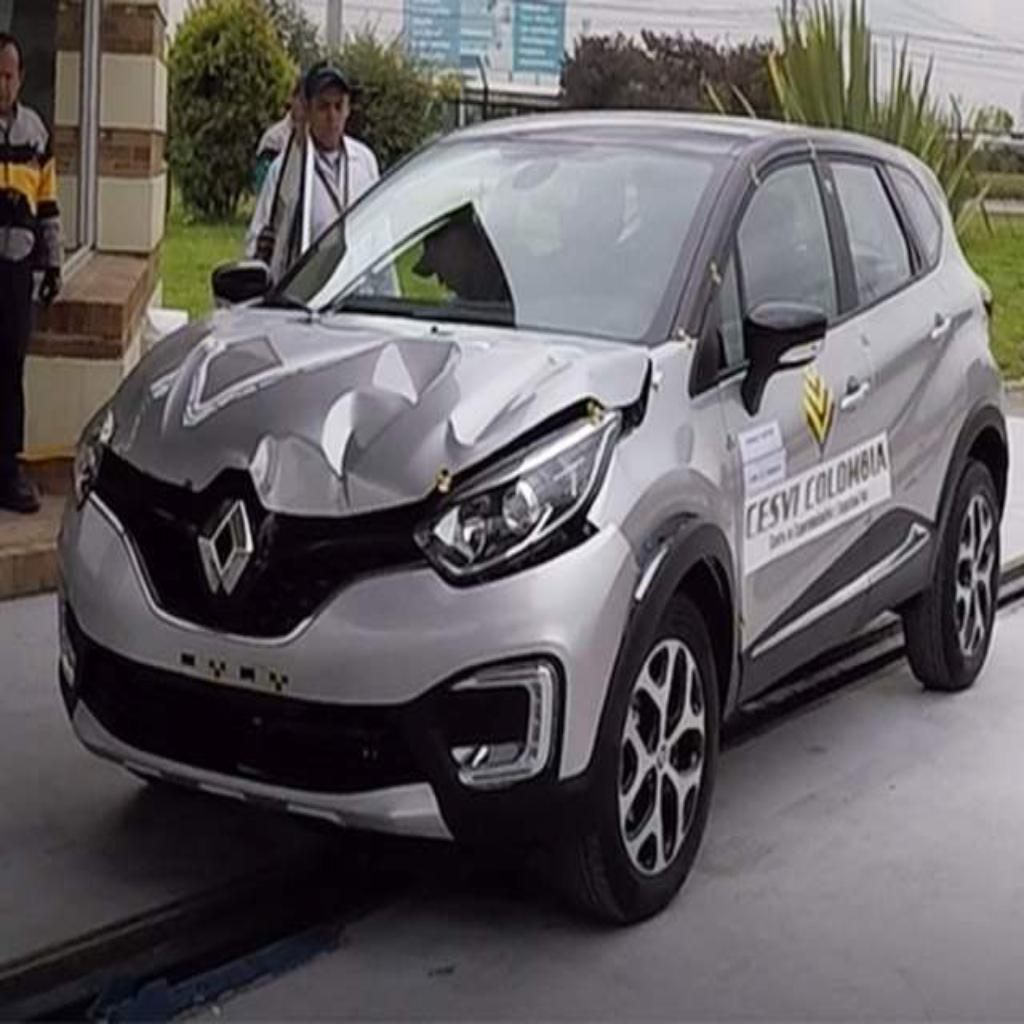

In [11]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

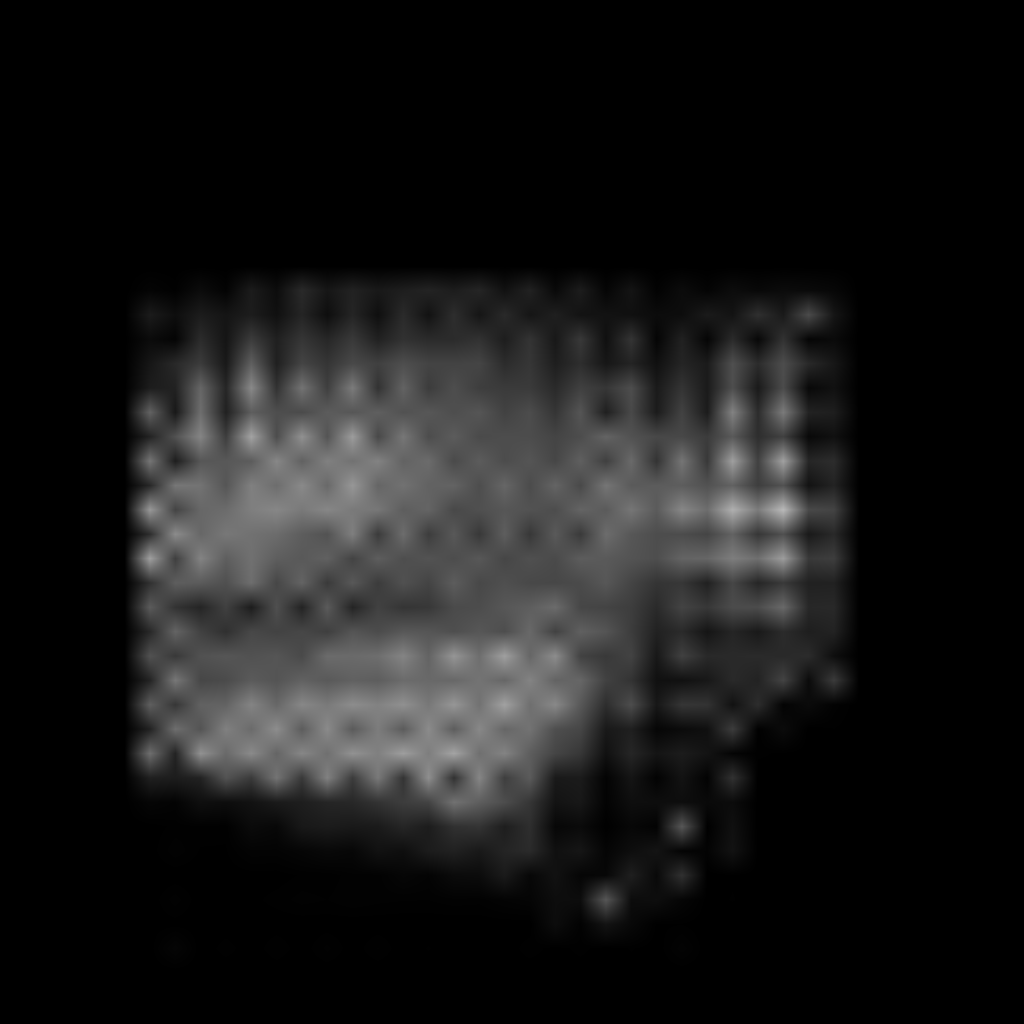

In [12]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())

## <br><b>References

Metallo, N., (2018). Car Damage Detector [online]. GitHub.<br> [Viewed 29 March 2020]. 
Available from: https://github.com/nicolasmetallo/car-damage-detector<br>

Mitchell, L., Sri.Yogesh, K. and Subramanian, V., (2019). Deep Learning with PyTorch 1.x, Packt Publishing, Birmingham<br>

PyTorch, (2017). TorchVision Object Detection Finetuning Tutorial [online]. PyTorch.org <br> [Viewed 19 March 2020]. Available from:
https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html

Sourish, N., (2019). Car damage detection using CNN [online]. GitHub.<br> [Viewed 12 March 2020]. Available from: https://github.com/nitsourish/car-damage-detection-using-CNN/tree/master